In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import itertools as it
import missingno as msno
import utils
import numpy as np
DATASET_PATH='../dataset/races.csv'
races_df=pd.read_csv(DATASET_PATH,
                     parse_dates=['date'],
                     #dtype=RACES_DTYPES
                     )
races_df['delta']=pd.to_timedelta(races_df['delta'],'seconds',errors='ignore')

# Cyclists data quality analysis

This notebook takes care of the data quality assessment for the cyclists data.

## dataset description
First we need to describe the dataset and the meaning of it's values to understand the analysis.

We have a tabular dataset composed by the following features:
- _url: unique identifier, it is composed of a string mad by the name of the races,the year and the stage, it is coded with a string.
- name: name of the race, coded with a string.
- points: pointss assigned to the race, coded with an integer in the range $[0,+\infty)$.
- uci_points: alternative points assigned to the race,coded with an integer in the range $[0,+\infty)$.
- length: total meters length of the race, coded with a floating point value in the range $[0,+\infty)$.
- climb_total: total meters climbed during the race,coded with a floating point value in the range $[0,+\infty)$.
- profile: the profile of the race, coded with integer values in the range \[1,2,3,4,5\].
- starlist_quality: quality of the participant, coded with an integer in the range $[0,+\infty)$.
- average_temperature: average temperature in celsius, coded with a float in the range $(-\infty,+\infty)$.
- position: position of the participant for that stage, coded with an integer in the range $[0,+\infty)$.
- cyclist: cyclist identifier, coded with a string.
- is_tarmac: boolean flag identifying the terrain is tarmac or not, coded with a boolean.
- is_cobbled: boolean flag identifying the terrain is tarmac or not, coded with a boolean.
- is_gravel: boolean flag identifying the terrain is tarmac or not, coded with a boolean.
- cyclist_team: team of the cyclist, coded with a string.
- date: date the race took place, coded using the datetime data type.
- delta: it's difference between the first person to arrive and the participant coded using the deltatime datatype, the value is expected to be non-negative.

## preliminary analysis

A first dumb check evidences no duplicate rows (at least across all features).

In [2]:
len(races_df[races_df.duplicated()])

0

A first preliminary analysis we can show how many values are currently missing from the dataset.

In [130]:
mv_df=pd.DataFrame(races_df.isnull().sum())
mv_df=mv_df.rename(columns={0:'missing values'})
mv_df['missing values']=mv_df['missing values'].astype('int')
mv_df['missing values %']=((mv_df['missing values']/len(races_df))*100).round(3)
mv_df.sort_values('missing values',ascending=False)

mv_cols=list(mv_df[mv_df['missing values'] > 0].index)
mv_cols.append('date')

mv_df

,missing values,missing values %
_url,0,0.000
name,0,0.000
points,477,0.081
uci_points,338779,57.433
length,0,0.000
climb_total,147045,24.929
profile,148194,25.123
startlist_quality,0,0.000
average_temperature,559932,94.925
date,0,0.000


The most missing features are the average temperature with almost all values missing, uci_points has more than half of it values missing and we also have the cyclist_team,profile and climb_total have around 25% of their values missing.
For all the other attributes the missing values are very few or none at all.

We can obtain a better visualization through a bar plot:

c:\projects\DataMiningProject\src\task1_data_understanding\utils.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  values['all other features']=0


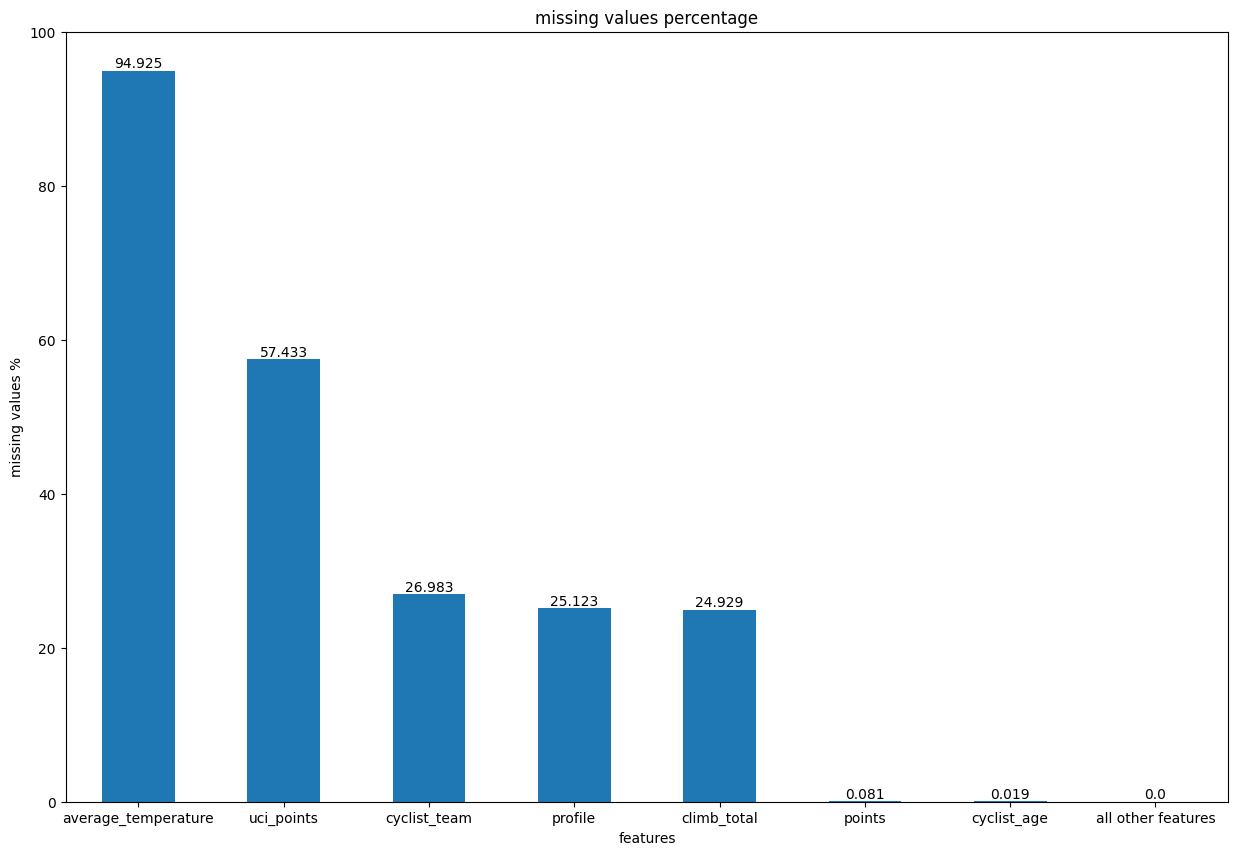

In [4]:
utils.plot_missing_values_barplot(mv_df)

# features in-domain analysis
We can do a first analysis on single features taking care of possible missing values,out-of-domain values or default values.
We can start with the analysis of the first two values.

## `_url` and `name`


The first attribute is redundant and contains duplicate information with no wrong or missing values w.r.t. to its duplicates, below we can see that the name of the race is correct and same goes for the year for each entry in the dataset.

Note: checking the name in `_url` to match the `name` feature is useless since the name attribute in the orginal dataset contains different values for the same races and cannot be confronted with the name contained in the `_url` attribute, but the name contained in _url is useful as it is standardized and avoids ambiguity.

In [135]:
# the feature has useful information to be used further in the analysis
url_df=races_df['_url'].str.split('/',expand=True)
url_df.rename(columns={0:'name',1:'year',2:'stage'},inplace=True)
url_df['original_name']=races_df['name']
url_df['original_year']=races_df['date'].dt.year.astype('int32')
url_df['year']=url_df['year'].astype('int32')
correct_years=len(url_df[url_df['original_year']==url_df['year']])
print(len(url_df)-correct_years)

0


## numerical values analysis

this part analises all the various numerical attributes checking if their non missing values are within their domain.

In [6]:
points=races_df['points'].dropna()
print('values lower than 0:',len(points[points<0]))

values lower than 0: 0


In [7]:
uci_points=races_df['uci_points'].dropna()
print('values lower than 0:',len(uci_points[uci_points<0]))

values lower than 0: 0


In [8]:
length=races_df['length'].dropna()
print('values lower than 0:',len(length[length<=0]))

values lower than 0: 0


In [9]:
climb_total=races_df['climb_total'].dropna()
print('values lower than 0:',len(climb_total[climb_total<=0]))

values lower than 0: 0


In [10]:
startlist_quality=races_df['startlist_quality'].dropna()
print('values lower than or equal to 0:',len(startlist_quality[startlist_quality<=0]))

values lower than or equal to 0: 0


In [11]:
average_temperature=races_df['average_temperature'].dropna()
print('average temperature values range',average_temperature.min(),"to",average_temperature.max())

average temperature values range 10.0 to 36.0


In [12]:
position=races_df['position'].dropna()
print('values lower than 0:',len(position[position<0]))

values lower than 0: 0


In [13]:
cyclist_age=races_df['cyclist_age'].dropna()
print('values lower than 0:',cyclist_age.min(),cyclist_age.max())

values lower than 0: 13.0 56.0


In [14]:
delta=races_df['delta'].dropna()
print('values lower than 0:',len(delta[delta<pd.Timedelta(0)]))

values lower than 0: 86


From these we can infer that all numerical values have correct values within range except for delta which has some values that are not.
## date analysis

We can continue with other kind of attributes, first the dates.

In [16]:
dates=races_df['date'].dropna()
print(dates.min(),dates.max())

1970-02-28 04:52:00 2023-07-29 05:52:14


The dates are all within a sensed range.

## profile analysis

We can now analise the profile for the races which is coded as integers in the range \[1,2,3,4,5\].

In [17]:
profile=races_df['profile'].dropna()
# values are coded with integers from 1 to 5
domain_values=[1,2,3,4,5]
print('out of range values :',len(profile[~profile.isin(domain_values)]))

out of range values : 0


Also here we don't have any range issues.

## is_X analysis

As for the is_X values we should have at least one flag True for each row

([<matplotlib.patches.Wedge at 0x1f6703a2570>,
 [Text(-1.055113366015054, 0.3110237689572657, 'at least one flag'),
  Text(1.0551133587350172, -0.3110237936539762, 'no flags')],
 [Text(-0.5755163814627567, 0.1696493285221449, '90.88'),
  Text(0.5755163774918275, -0.1696493419930779, '9.12')])

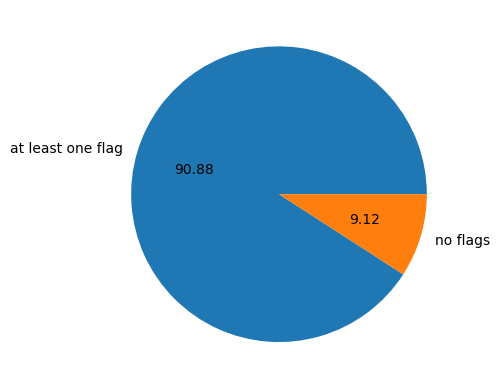

In [31]:
is_X_df=races_df[['is_tarmac','is_cobbled','is_gravel']]
is_X_value=is_X_df.sum(axis=1).value_counts().values

plt.pie(x=is_X_value,
        labels=[
                f'at least one flag',
                f'no flags'
        ] ,
        autopct='%1.2f',
        )

But as we can see that is not true, it should be determined if the terrain can be another type or is just missing the values.

# races names

We can now analize the names of the races.

In [46]:
names=races_df['name'].unique()
names.sort()
names,len(names)

(array(['Amstel Gold Race', 'Clasica Ciclista San Sebastian',
        'Clásica Ciclista San Sebastian', 'Clásica Ciclista San Sebastián',
        'Clásica San Sebastián', 'Criterium du Dauphiné',
        'Criterium du Dauphiné Libére', 'Critérium du Dauphiné',
        'Critérium du Dauphiné Libéré', 'Donostia San Sebastian Klasikoa',
        'Dwars door België / À travers la Belgique',
        'Dwars door Vlaanderen',
        'Dwars door Vlaanderen - A travers la Flandre ME',
        'Dwars door Vlaanderen / A travers la Flandre',
        'Dwars door Vlaanderen / A travers la Flandre ME',
        'E3 BinckBank Classic', 'E3 Harelbeke', 'E3 Prijs Vlaanderen',
        'E3 Prijs Vlaanderen - Harelbeke', 'E3 Saxo Bank Classic',
        'E3 Saxo Classic', 'E3-Prijs Harelbeke', "Giro d'Italia",
        'Giro di Lombardia', 'Gran Camiño',
        'Grand Prix Cycliste de Montréal', 'Grand Prix Cycliste de Quebec',
        'Grand Prix Cycliste de Québec', 'Il Lombardia',
        'Itzulia Basque

By observing the output we can see that some races have duplicate names with some syntax errors, so we could have duplicates or have different races for some of them i.e. they are the same race with different name or a different race at all.

## missing values matrix across time

We've seen until now just the single missing values, to understand better our dataset we can correlate missing values with time to see any meaningful pattern.

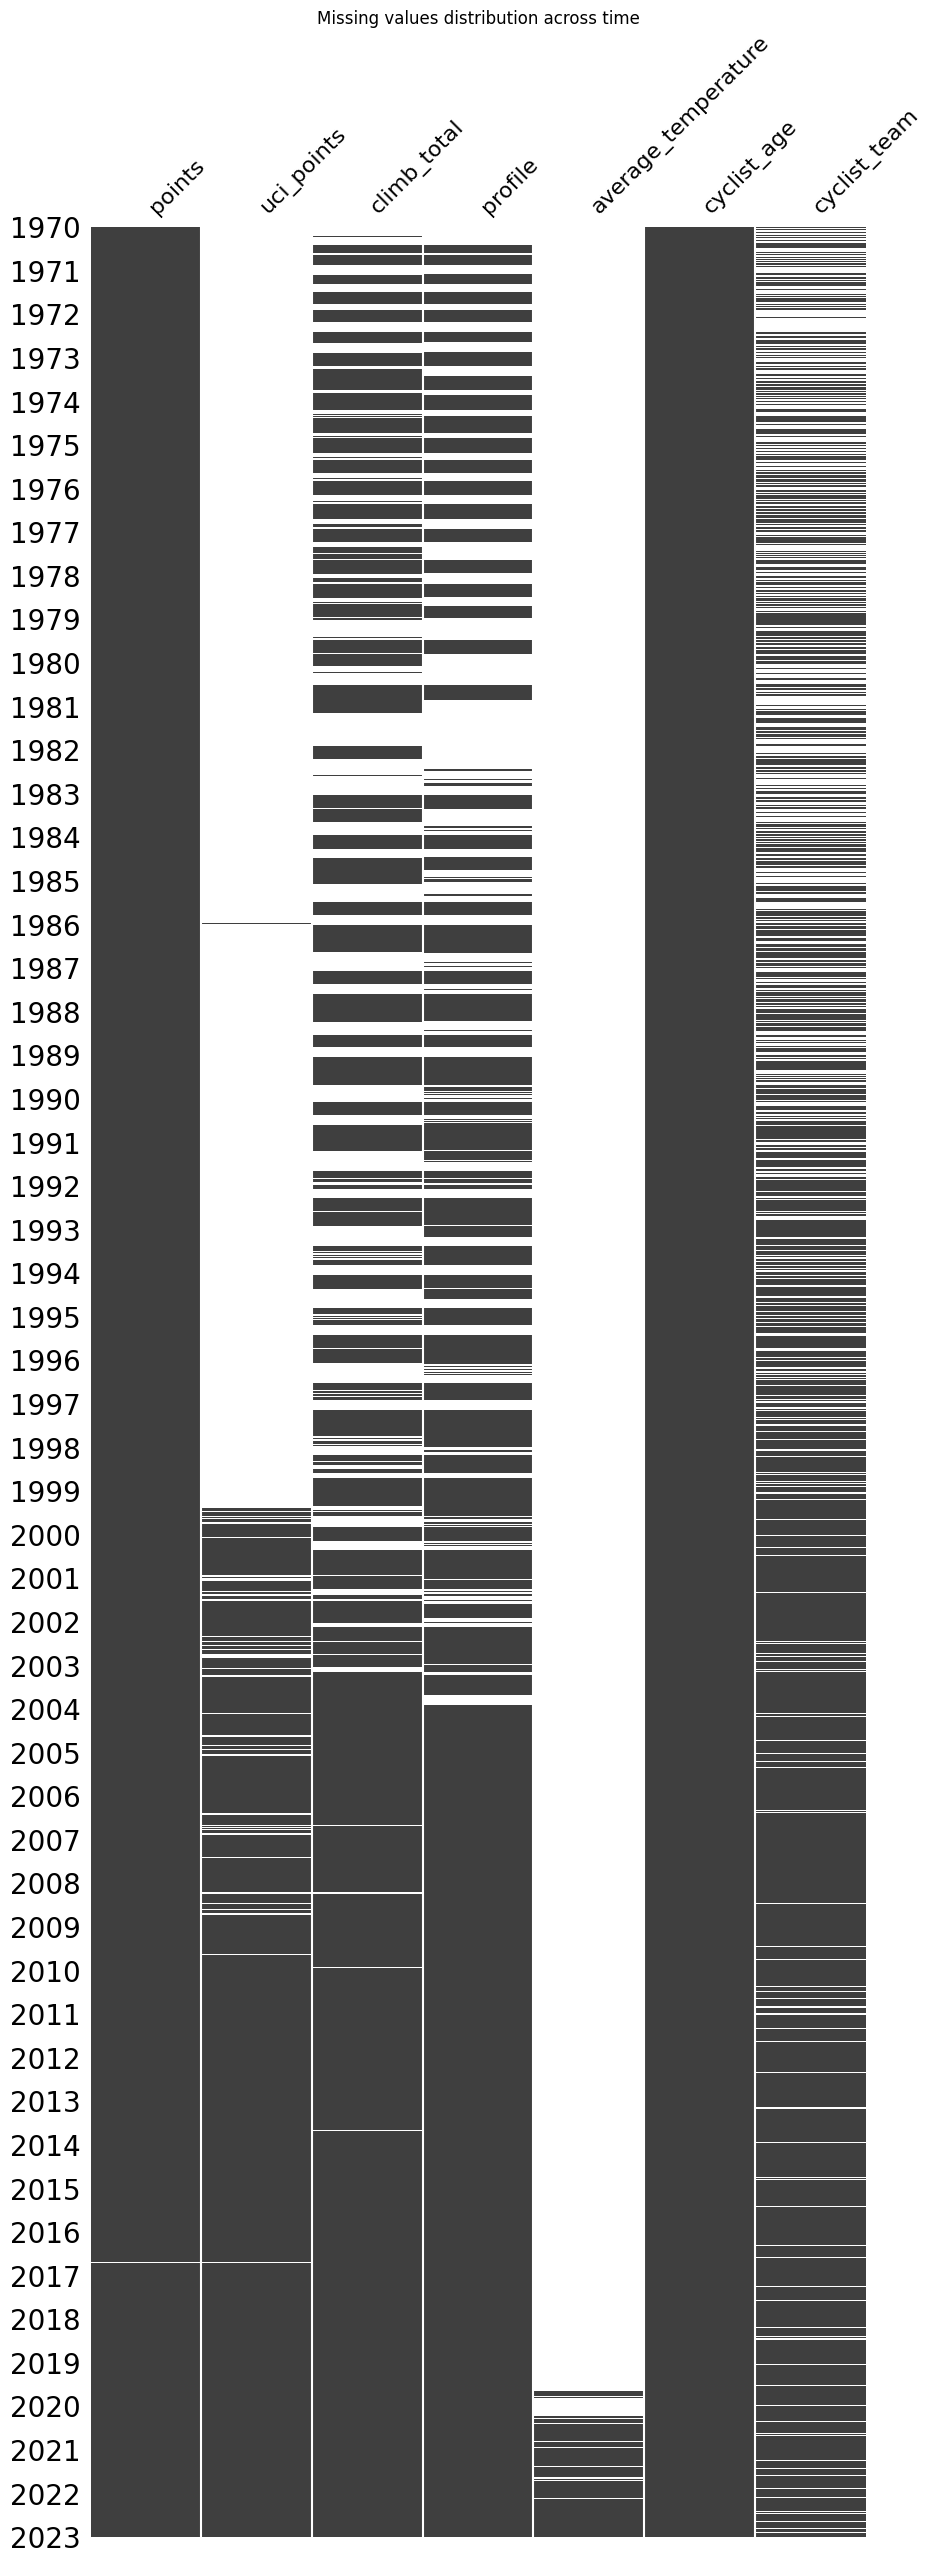

In [18]:
utils.plot_msno_matrix(races_df[mv_cols])

As we can see uci_points are missing until 2000 while the average temperature is missing until 2020. Also climb_total and profile have some gaps until 2004 where they stop missing entirely while cyclist_team has some missing values across all the years with a concentration on years before 1998.

## missing values correlation heatmap

Observing the plot above we can see that profile and climb total seem to be highly correlated and both are present or missing together, this can be proved by plotting a missing values correlation map below.

<Axes: >

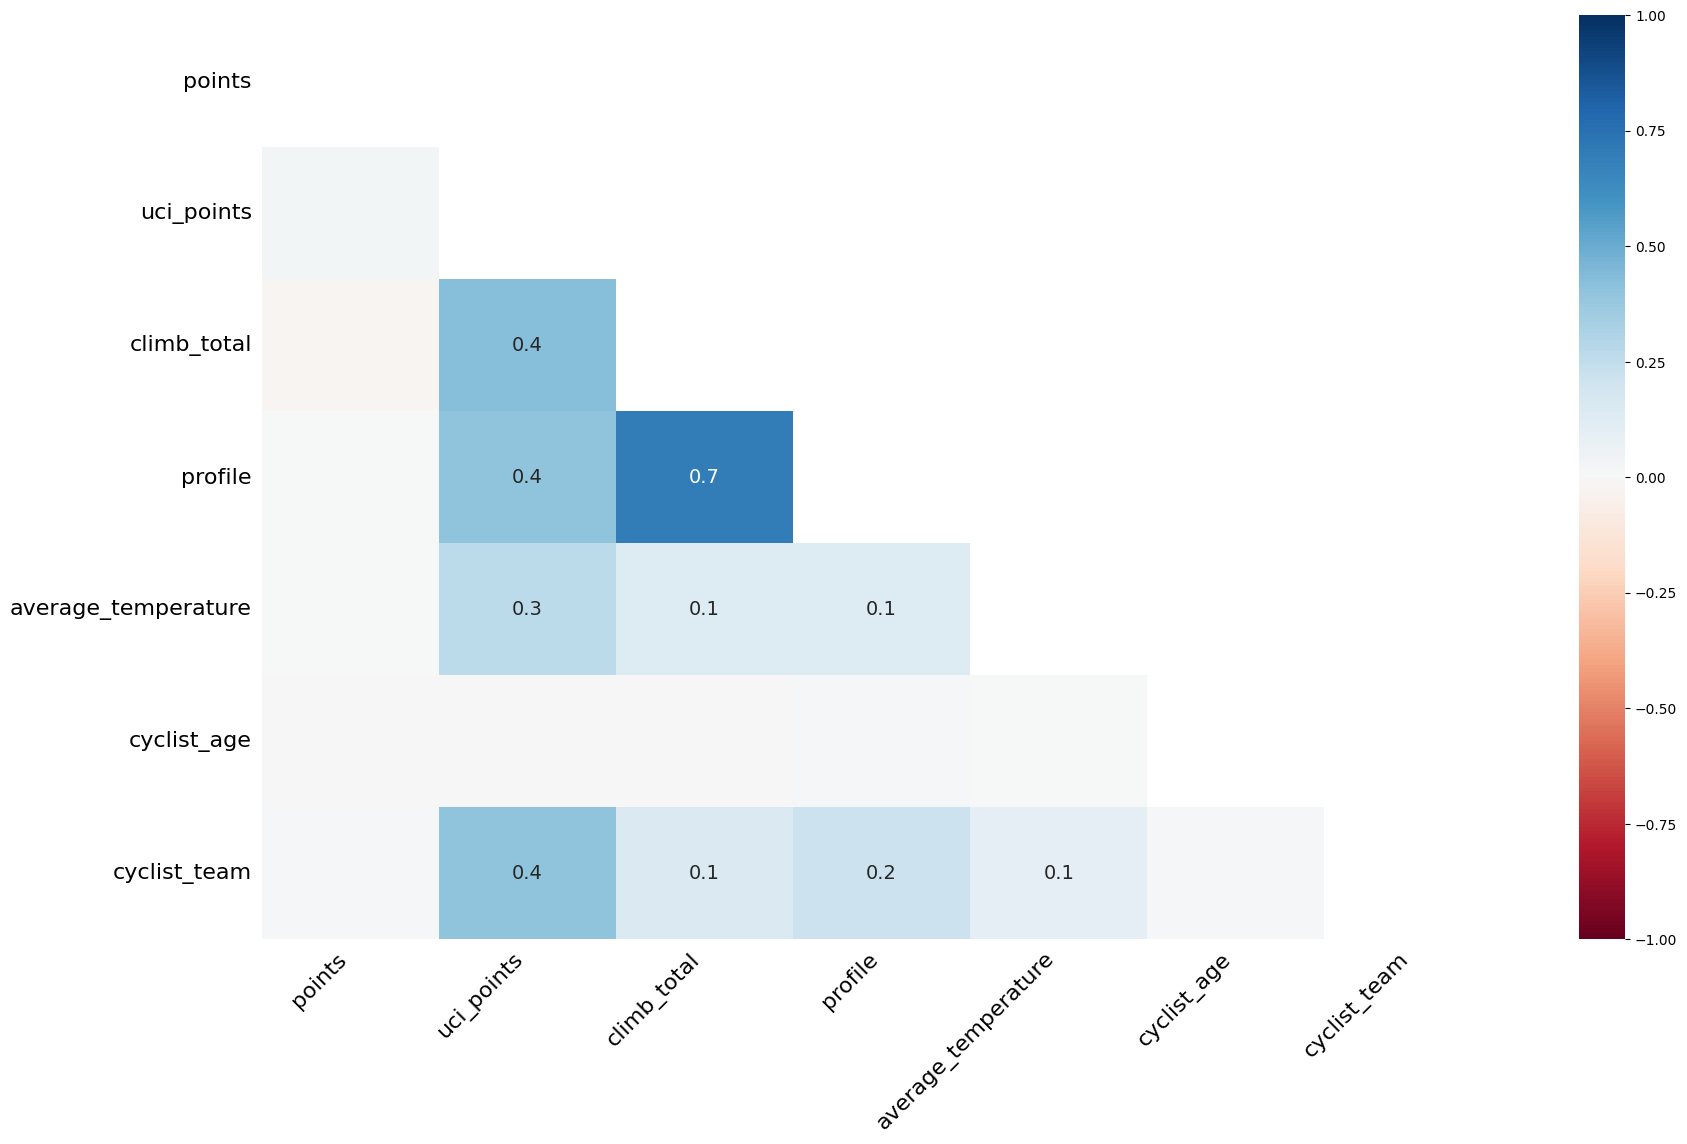

In [139]:
msno.heatmap(races_df)

# missing values per race

Finally another interesting insight is the missing values per race.

<Axes: title={'center': 'missing values per race'}, xlabel='missing value counts', ylabel='race name'>

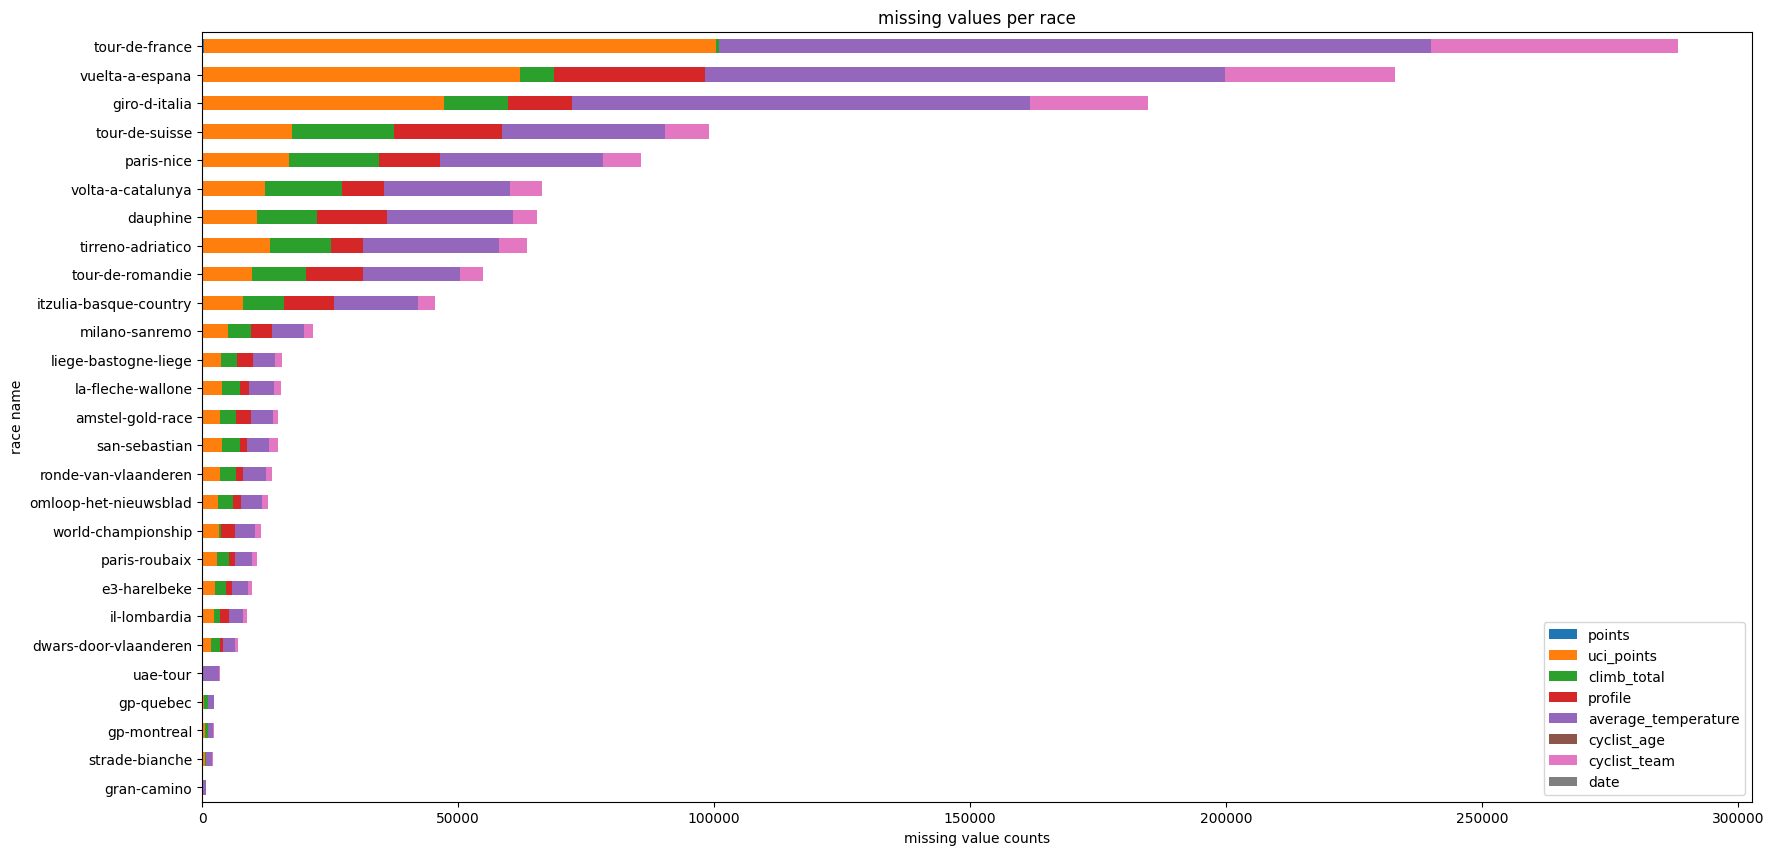

In [148]:
races_mv_df=races_df
races_mv_df['url_name']=url_df['name']
races_mv_df=races_mv_df.groupby('url_name').apply(lambda x: x.isnull().sum())
races_mv_ord=races_mv_df.sum(axis=1).sort_values().index
races_mv_df[mv_cols].reindex(races_mv_ord).plot(kind='barh',stacked=True,figsize=(20,10),title='missing values per race',xlabel='missing value counts',ylabel='race name',use_index=True)

As we can see the most missing value, as to be expected, is the average temperature along with uci_points.